# Planesnet Classification Using MXNet Gluon

### This notebook uses the Planesnet dataset, which can be found here: https://github.com/rhammell/planesnet The dataset contains 32,000 images 20x20 pixel RGB images. There are 8,000 images contain airplanes and 24,000 images with no airplanes. The goal of this notebook is to train a Convolutional Neural Network (CNN) using the MXNet Gluon framework to detect airplanes in overhead airport imagery.  

<p> To begin, import the necessary high-level libraries and get the Sagemaker execution role. Then we will point the inputs for the SageMaker training container to an S3 bucket. This will allow us to load data directly from S3 to our training instance without having to host the data locally on this notebook. </p>

In [ ]:
import os
import boto3
import sagemaker
from sagemaker.mxnet import MXNet
from mxnet import gluon
from sagemaker import get_execution_role

sagemaker_session = sagemaker.Session()

role = get_execution_role()

In [2]:
#Loads planesnet data into S3 - only run this once!
inputs = sagemaker_session.upload_data(path='recordIOs', key_prefix='recfiles')

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-951232522638


<p> Below is a preview of the Gluon CNN python code. The lines of code actuall defining this CNN are:

<pre><code>def define_network():
    net = nn.Sequential()
    with net.name_scope():
        net.add(nn.Conv2D(32, 3, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=(2,2)))
        net.add(nn.Conv2D(64, 3, activation='relu'))
        net.add(nn.Conv2D(64, 3, activation='relu'))
        net.add(nn.MaxPool2D(pool_size=(2,2)))
        net.add(nn.Dense(512, activation='relu'))
        net.add(nn.Dropout(0.5))
        net.add(nn.Dense(2))
    return net
</code></pre>
    
So there are 3 Convolutional layers, 2 Pooling layers, 1 Fully connected layer, and 50% Dropout being used to prevent over-fitting. The Final Dense layer produces 2 outputs, making this a binary classification problem. This model with predict yes there is a plane, or no there is not a plane.</p>

In [3]:
!cat 'planesnet-gluon.py'

from __future__ import print_function

import logging
import mxnet as mx
from mxnet import gluon, autograd
from mxnet.gluon import nn
import numpy as np
import json
import time


logging.basicConfig(level=logging.DEBUG)

# ------------------------------------------------------------ #
# Training methods                                             #
# ------------------------------------------------------------ #


def train(channel_input_dirs, hyperparameters, hosts, num_gpus, **kwargs):
    # SageMaker passes num_cpus, num_gpus and other args we can use to tailor training to
    # the current container environment, but here we just use simple cpu context.
    ctx = mx.cpu()

    # retrieve the hyperparameters we set in notebook (with some defaults)
    batch_size = hyperparameters.get('batch_size', 100)
    epochs = hyperparameters.get('epochs', 10)
    learning_rate = hyperparameters.get('learning_rate', 0.1)
    log_interval = hyperparameters.get('log_interval', 100)

    # load tra

<p> The following 3 blocks will first define the MXNet Model using the SageMaker API, then it fill train the model by called the fit function, and lastly it will deploy an endpoint that hosts the model. </p>

In [4]:
m = MXNet("planesnet-gluon.py", 
          role=role, 
          train_instance_count=1, 
          train_instance_type="ml.c4.xlarge",
          hyperparameters={'batch_size': 128, 
                         'epochs': 50, 
                         'learning_rate': 0.001, 
                         'log_interval': 100})

In [5]:
m.fit(inputs)

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-951232522638
INFO:sagemaker:Creating training-job with name: sagemaker-mxnet-py2-cpu-2018-01-27-15-20-34-855


................................................................
executing startup script (first run)
2018-01-27 15:25:40,688 INFO - root - running container entrypoint
2018-01-27 15:25:40,689 INFO - root - starting train task
2018-01-27 15:25:41,907 INFO - mxnet_container.train - MXNetTrainingEnvironment: {'enable_cloudwatch_metrics': False, 'available_gpus': 0, 'channels': {u'training': {u'TrainingInputMode': u'File', u'RecordWrapperType': u'None', u'S3DistributionType': u'FullyReplicated'}}, '_ps_verbose': 0, 'resource_config': {u'current_host': u'algo-1', u'hosts': [u'algo-1']}, 'user_script_name': u'planesnet-gluon.py', 'input_config_dir': '/opt/ml/input/config', 'channel_dirs': {u'training': u'/opt/ml/input/data/training'}, 'code_dir': '/opt/ml/code', 'output_data_dir': '/opt/ml/output/data/', 'output_dir': '/opt/ml/output', 'model_dir': '/opt/ml/model', 'hyperparameters': {u'sagemaker_program': u'planesnet-gluon.py', u'learning_rate': 0.001, u'batch_size': 128, u'epochs': 50, u'

[Epoch 32] Validation: accuracy=0.962344
[Epoch 33 Batch 100] Training: accuracy=0.976253, 764.946636 samples/s
[Epoch 33] Training: accuracy=0.974883
[Epoch 33] Validation: accuracy=0.963125
[Epoch 34 Batch 100] Training: accuracy=0.972153, 836.164171 samples/s
[Epoch 34] Training: accuracy=0.970469
[Epoch 34] Validation: accuracy=0.966250
[Epoch 35 Batch 100] Training: accuracy=0.974706, 768.242508 samples/s
[Epoch 35] Training: accuracy=0.972695
[Epoch 35] Validation: accuracy=0.955000
[Epoch 36 Batch 100] Training: accuracy=0.977027, 760.524409 samples/s
[Epoch 36] Training: accuracy=0.973594
[Epoch 36] Validation: accuracy=0.959844
[Epoch 37 Batch 100] Training: accuracy=0.977413, 747.528056 samples/s
[Epoch 37] Training: accuracy=0.977695
[Epoch 37] Validation: accuracy=0.965000
[Epoch 38 Batch 100] Training: accuracy=0.981745, 717.674699 samples/s
[Epoch 38] Training: accuracy=0.980547
[Epoch 38] Validation: accuracy=0.967812
[Epoch 39 Batch 100] Training: accuracy=0.969910, 786

In [ ]:
predictor = m.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: sagemaker-mxnet-py2-cpu-2018-01-27-15-20-34-855
INFO:sagemaker:Creating endpoint with name sagemaker-mxnet-py2-cpu-2018-01-27-15-20-34-855


-----------------------------------------------------------------------------------------------------------------------------

##### Now that our endpoint is deployed, lets try to detect the planes in the following overhead image.

<p> We will use a technique called a sliding window detection and apply it to a larger scene. The sliding window detection defines a window of a fixed size and moves that window across the image which a specified amount of overlap. The window size and overlap are specified by the win and step parameters. The open source detection algorithm has been adapted from https://github.com/bikz05/object-detector </p>

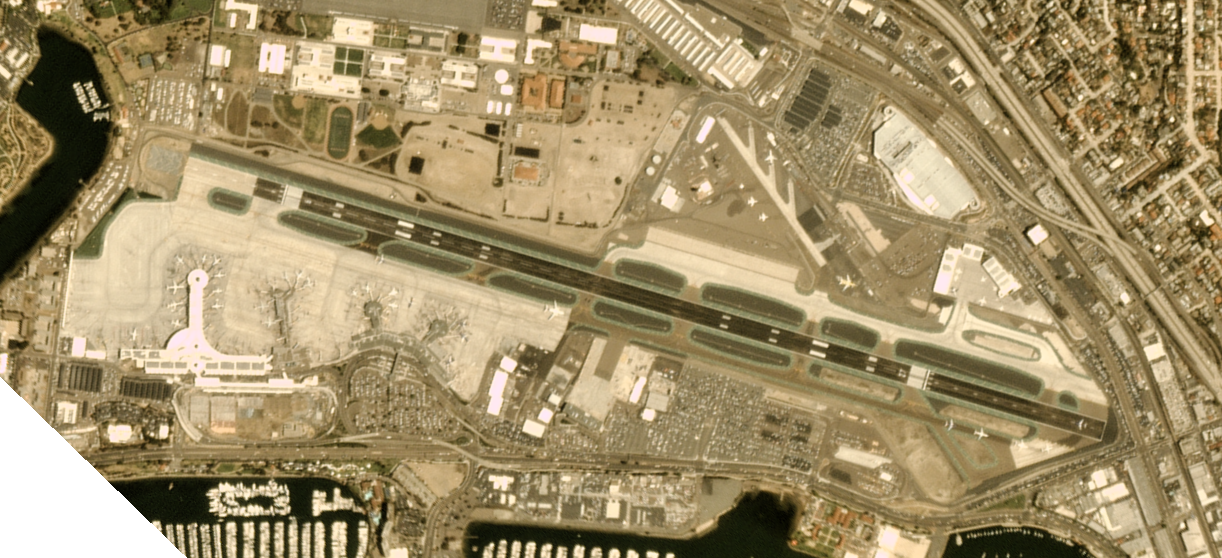

In [82]:
file_name = 'test-images/planesnet/scene_2.png'
# test image
from IPython.display import Image
Image(file_name)

In [135]:
import numpy as np
import cv2
import time
import os
import matplotlib.pyplot as plt
from scipy.misc import imsave, imread
from tqdm import tqdm


# Define a function that takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop, y_start_stop, xy_window, xy_overlap):

    # Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    # Initialize a list to append window positions to
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]

            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list


# Define a function you will pass an image
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    test_features = []
    ct = 1
    #2) Iterate over all windows in the list
    for window in tqdm(windows):
        
        if window[1][0] > 1222 :
            print('error x out of bounds')
            print(window[1][0])
        elif window[0][1] > 558:
            print('error y out of bounds')
            print(window[0][1])
        elif window[0][0] > window[1][0] :
            print('x-cords messed up')
        elif window[0][1] > window[1][1]:
            print('y-cords messed up')
        
        #3) Extract the test window from original image        
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (20, 20))

        #4) Scale extracted features to be fed to classifier
        test_features = np.expand_dims(test_img, axis=1).transpose([1, 3, 0, 2])
        
        #5) Predict using your classifier
        prediction = predictor.predict(test_features)
        
        #6) If positive (prediction == 1) then save the window    
        if prediction == 1.0:
            on_windows.append(window) 

        ct = ct + 1
    #7 Return windows for positive detections
    return on_windows


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

/home/ec2-user/anaconda3/envs/mxnet_p27/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
100%|██████████| 24648/24648 [06:08<00:00, 66.82it/s]


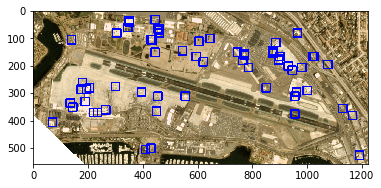

CPU times: user 57.3 s, sys: 2.11 s, total: 59.4 s
Wall time: 6min 9s


In [136]:
%%time
from PIL import Image

in_fname = 'test-images/planesnet/scene_2.png'
img = imread(in_fname)
arr = np.array(img)[:,:,0:3]
shape = arr.shape

# Set output fname
out_fname = os.path.splitext(in_fname)[0] + '_detection.png'

# Sliding window parameters
win = 30
step = 0.8
draw_image = np.copy(img)

windows = slide_window(img, x_start_stop=(0, shape[1]-win), y_start_stop=(0, shape[0]-win),
                    xy_window=(win, win), xy_overlap=(step, step))

hot_windows = search_windows(img, windows)


window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=2)

plt.imshow(window_img)
plt.show()

# Save output image
outIm = Image.fromarray(window_img)
outIm.save(out_fname)

##### The first image below used a 30x30 pixel window with 80% overlap. It took 6 minutes for the detection calculation to complete but it has a high number of false positive detections. The second image below took 58 minutes to for the detection calculation to complete. As you can see, it achieved a much higher accuracy. This is because the window used was 20x20 pixels with 90% overlap. Feel free to change the win and step parameters above to see how adjusting these values impact speed and accuracy.a

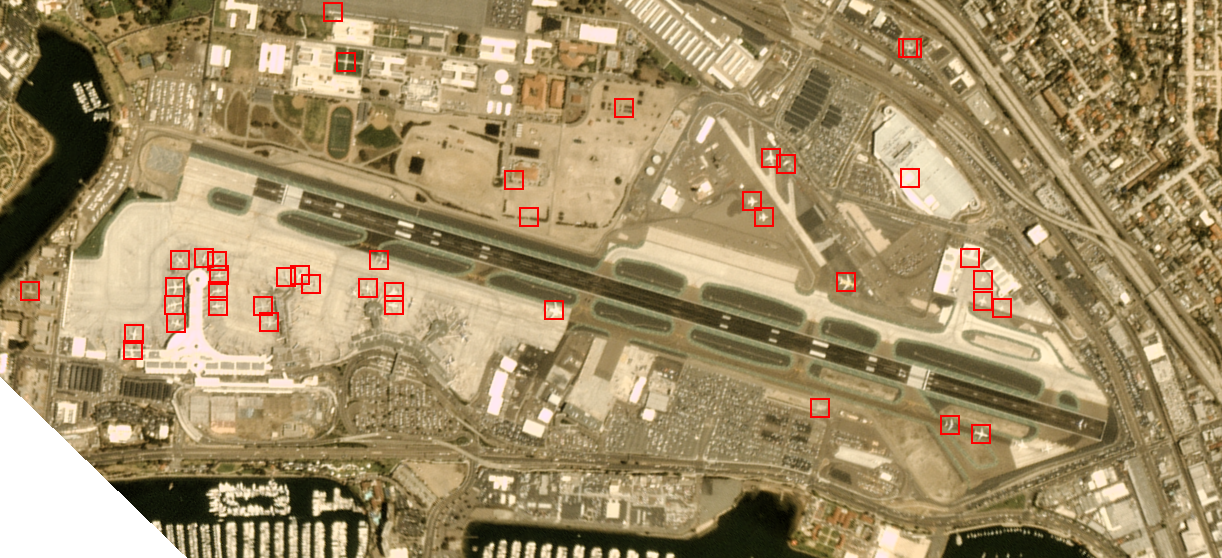

In [118]:
file_name = 'test-images/planesnet/scene_2_detections_goldcopy.png'

# test image
from IPython.display import Image
Image(file_name)